In [32]:
import keras
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

In [33]:
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline

### データ作成

In [6]:
random.seed(42)
# 乱数の係数
random_factor = 0.05
# サイクルあたりのステップ数
steps_per_cycle = 80
# 生成するサイクル数
number_of_cycles = 50

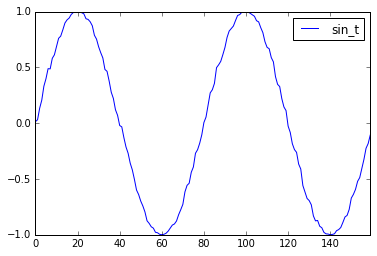

In [7]:
df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
df[["sin_t"]].head(steps_per_cycle * 2).plot()

In [25]:
print(df.head())
print(df.tail())
print(df.shape)

   t     sin_t
0  0  0.013942
1  1  0.031036
2  2  0.134177
3  3  0.206445
4  4  0.331418
         t     sin_t
3996  3996 -0.298084
3997  3997 -0.278004
3998  3998 -0.128338
3999  3999 -0.078127
4000  4000 -0.038239
(4001, 2)


### データ整形
- 0-99番目の100個の入力があったら、100番目を予測するデータを作る。つまり、１レコード、100次元。

In [8]:
def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1, n_prev = 100):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))
    ntrn = int(ntrn)
    X_train, y_train = _load_data(df.iloc[0:ntrn], n_prev)
    X_test, y_test = _load_data(df.iloc[ntrn:], n_prev)

    return (X_train, y_train), (X_test, y_test)


In [9]:
length_of_sequences = 100
(X_train, y_train), (X_test, y_test) = train_test_split(df[["sin_t"]], n_prev =length_of_sequences)  

In [31]:
X_train

array([[[ 0.01394223],
        [ 0.03103591],
        [ 0.13417666],
        ..., 
        [ 0.97304546],
        [ 0.99395919],
        [ 0.99909863]],

       [[ 0.03103591],
        [ 0.13417666],
        [ 0.20644523],
        ..., 
        [ 0.99395919],
        [ 0.99909863],
        [ 0.99880698]],

       [[ 0.13417666],
        [ 0.20644523],
        [ 0.33141825],
        ..., 
        [ 0.99909863],
        [ 0.99880698],
        [ 0.99494288]],

       ..., 
       [[-0.98755734],
        [-0.99454999],
        [-0.99889502],
        ..., 
        [-0.40118282],
        [-0.28979232],
        [-0.198227  ]],

       [[-0.99454999],
        [-0.99889502],
        [-0.99943642],
        ..., 
        [-0.28979232],
        [-0.198227  ],
        [-0.13547434]],

       [[-0.99889502],
        [-0.99943642],
        [-0.99164591],
        ..., 
        [-0.198227  ],
        [-0.13547434],
        [-0.03498147]]])

In [36]:
df.ix[100:102,]

,t,sin_t
100,100,0.998807
101,101,0.994943
102,102,0.984683


In [30]:
y_train

array([[ 0.99880698],
       [ 0.99494288],
       [ 0.98468286],
       ..., 
       [-0.13547434],
       [-0.03498147],
       [ 0.01325794]])

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3501, 100, 1)
(300, 100, 1)
(3501, 1)
(300, 1)


### Kerasのモデル生成
- (, 100, 1)のtensorを持った入力を３００個のLSTM中間層に投げ，それを1個の出力層に集約し，linear活性化関数を掛け合わせる

In [37]:
in_out_neurons = 1
hidden_neurons = 300

In [10]:
model = Sequential()  
model.add(LSTM(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False))  
model.add(Dense(in_out_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.fit(X_train, y_train, batch_size=600, nb_epoch=15, validation_split=0.05) 

Train on 3325 samples, validate on 176 samples
Epoch 1/15
3325/3325 [==============================] - 150s - loss: 0.2274 - val_loss: 0.0113
Epoch 2/15
3325/3325 [==============================] - 127s - loss: 0.0205 - val_loss: 0.0012
Epoch 3/15
3325/3325 [==============================] - 122s - loss: 0.0011 - val_loss: 0.0023
Epoch 4/15
3325/3325 [==============================] - 114s - loss: 0.0113 - val_loss: 0.0212
Epoch 5/15
3325/3325 [==============================] - 117s - loss: 0.0082 - val_loss: 0.0077
Epoch 6/15
3325/3325 [==============================] - 123s - loss: 0.0097 - val_loss: 0.0108
Epoch 7/15
3325/3325 [==============================] - 115s - loss: 0.0061 - val_loss: 0.0090
Epoch 8/15
3325/3325 [==============================] - 116s - loss: 0.0083 - val_loss: 0.0128
Epoch 9/15
3325/3325 [==============================] - 117s - loss: 0.0115 - val_loss: 0.0086
Epoch 10/15
3325/3325 [==============================] - 116s - loss: 0.0046 - val_loss: 0.0057
Ep

In [11]:
predicted = model.predict(X_test) 

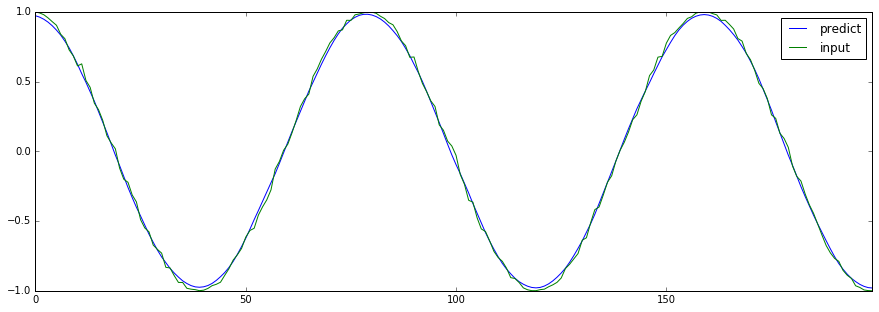

In [12]:
dataf =  pd.DataFrame(predicted[:200])
dataf.columns = ["predict"]
dataf["input"] = y_test[:200]
dataf.plot(figsize=(15, 5))

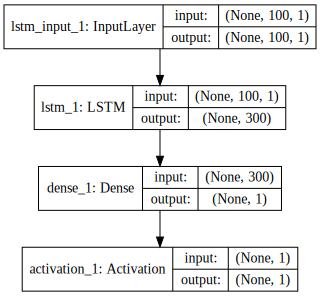

In [16]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot, plot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))